In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
def build_master_df(data, label):
    frames = {}
    list_of_dfs = []

    for i in range(len(data['locations'])):
        coordinates = str(data['locations'][i]['coordinates'])
        country = data['locations'][i]['country']
        country_code = data['locations'][i]['country_code']
        province = data['locations'][i]['province']
        history = data['locations'][i]['history']
        df = pd.DataFrame(history, index=[0]).T
        df.reset_index(inplace=True)
        df.columns = ['date', 'count']
        df['date'] = pd.to_datetime(df['date'])
        df['country'] = country
        df['coordinates'] = coordinates
        df['country_code'] = country_code
        df['province'] = province

        country_key = country + '_' + str(i) # they key is never referenced elsewhere... just for building dict of df
        frames[country_key] = df # add to dict of dfs
        
    for key in frames.keys():
        list_of_dfs.append(frames[key]) # this needs to be key, not country key, IMPORTANT

    master_df = pd.concat(list_of_dfs)
    master_df = master_df.reset_index(drop=True)
    master_df['data_type'] = label

    return master_df

In [3]:
api_url = 'https://coronavirus-tracker-api.herokuapp.com/all'

In [4]:
json_data = pd.read_json(api_url)

In [5]:
confirmed_data = json_data['confirmed']
death_data = json_data['deaths']
recovered_data = json_data['recovered']

full_confirmed_df = build_master_df(confirmed_data, 'confirmed')
full_death_df = build_master_df(death_data, 'death')
full_recovered_df = build_master_df(recovered_data, 'recovered')

full_df = pd.concat([full_confirmed_df, full_death_df, full_recovered_df])
full_df.reset_index(drop=True, inplace=True)

In [6]:
full_df['date'].max() # last update was less than 24h ago

Timestamp('2020-03-19 00:00:00')

In [8]:
china_provinces = sorted(full_df[full_df['country'] == 'China']['province'].unique())
for province in china_provinces:
    country_lookup = 'China'
    province_lookup = province
    df = full_df[(full_df['country'] == country_lookup) & (full_df['province'] == province_lookup)]
    count = int(df.tail(1)['count'])
    print(province, count)

Anhui 984
Beijing 315
Chongqing 542
Fujian 295
Gansu 88
Guangdong 1260
Guangxi 230
Guizhou 123
Hainan 159
Hebei 307
Heilongjiang 430
Henan 1247
Hong Kong 59
Hubei 46488
Hunan 979
Inner Mongolia 70
Jiangsu 621
Jiangxi 923
Jilin 91
Liaoning 109
Macau 10
Ningxia 71
Qinghai 18
Shaanxi 227
Shandong 700
Shanghai 315
Shanxi 127
Sichuan 466
Tianjin 130
Tibet 1
Xinjiang 73
Yunnan 170
Zhejiang 1176


In [9]:
country_lookup = 'China'
province_lookup = 'Hubei'
df = full_df[(full_df['country'] == country_lookup) & (full_df['province'] == province_lookup)]
int(df.tail(1)['count'])

46488

In [10]:
def get_country_data(country, province=None):
    
    if province == None:
        # country lookup (where there is no province)
        df = full_df[full_df['country'] == country]

    else:
        # country and province lookup
        df = full_df[(full_df['country'] == country) & (full_df['province'] == province)]

    df.sort_values(['date', 'data_type'], inplace=True)
    df = df[['date', 'count', 'data_type']]
    df = pd.pivot_table(df, values='count', index='date', columns='data_type')
    df.reset_index(inplace=True)

    data_types = ['confirmed', 'death', 'recovered']

    df.set_index('date', inplace=True)

    # feature engineering
    df['death_rate'] = df['death'] / df['confirmed']
    df['recovered_rate'] = df['recovered'] / df['confirmed']
    df['confirmed_change'] = df['confirmed'] - df['confirmed'].shift(1)
    df['death_change'] = df['death'] - df['death'].shift(1)
    df['recovered_change'] = df['recovered'] - df['recovered'].shift(1)
    df['confirmed_change_rate'] = df['confirmed_change'] / df['confirmed']
    df['death_change_rate'] = df['death_change'] / df['death']
    df['recovered_change_rate'] = df['recovered_change'] / df['recovered']
    df.fillna(0, inplace=True)

    # get rid of zero confirm dates
    df = df[df['confirmed'] > 0]

    # sort columns
    columns = sorted(df.columns)
    df = df[columns]

    return df

In [11]:
country = 'Japan'
province = None

df = get_country_data(country, province)

In [13]:
df['confirmed_change_rate'].tail(20)

date
2020-02-29    0.053942
2020-03-01    0.058594
2020-03-02    0.065693
2020-03-03    0.064846
2020-03-04    0.114804
2020-03-05    0.080556
2020-03-06    0.142857
2020-03-07    0.088937
2020-03-08    0.081673
2020-03-09    0.017613
2020-03-10    0.120482
2020-03-11    0.090767
2020-03-12    0.000000
2020-03-13    0.088445
2020-03-14    0.093144
2020-03-15    0.078665
2020-03-16   -0.016970
2020-03-17    0.060364
2020-03-18    0.012373
2020-03-19    0.037879
Name: confirmed_change_rate, dtype: float64

In [14]:
ewm_df = df[['confirmed_change_rate']]

df['smooth.5'] = ewm_df.ewm(com=0.5).mean()#.astype(int)
df['smooth.7'] = ewm_df.ewm(com=0.7).mean()#.astype(int)
df['smooth.9'] = ewm_df.ewm(com=0.9).mean()#.astype(int)

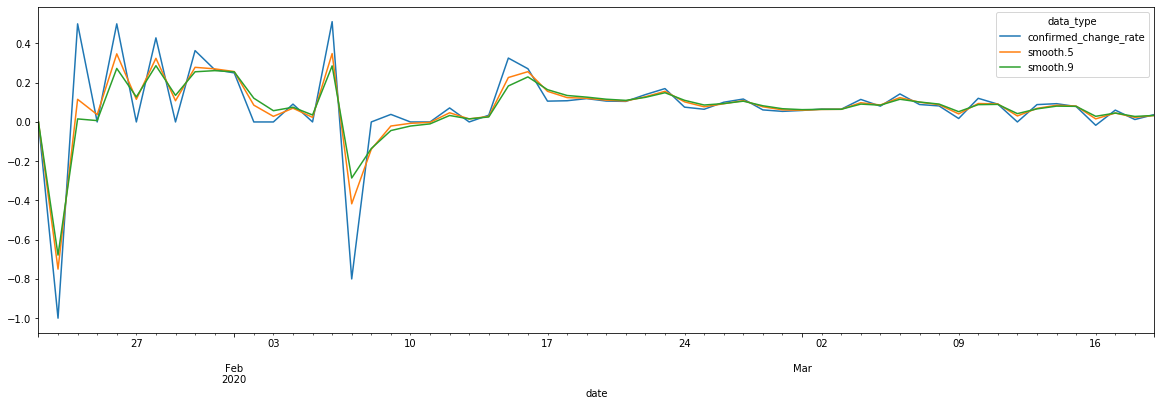

In [15]:
df[['confirmed_change_rate', 'smooth.5', 'smooth.9']].plot(figsize=(20, 6))

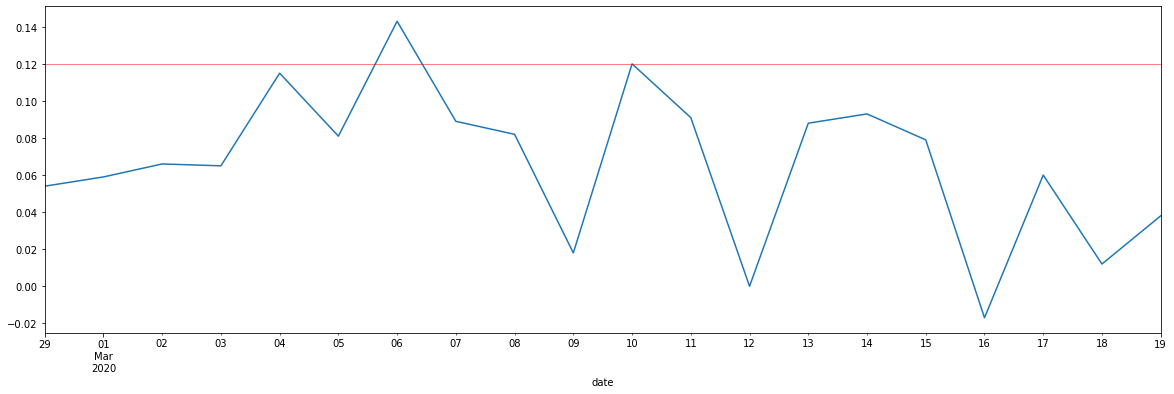

In [16]:
df['confirmed_change_rate'].tail(20).round(3).plot(figsize=(20, 6))
plt.axhline(y=0.12, color='r', linestyle='-', linewidth=0.5)

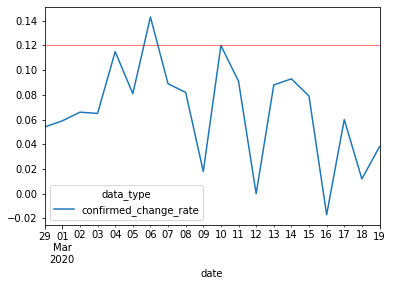

In [17]:
df[['confirmed_change_rate']].tail(20).round(3).plot()
plt.axhline(y=0.12, color='r', linestyle='-', linewidth=0.5)

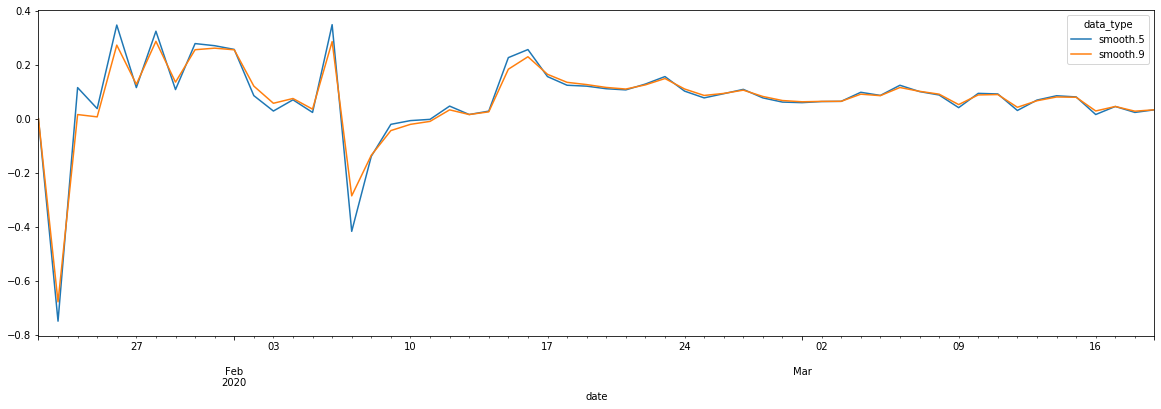

In [18]:
df[['smooth.5', 'smooth.9']].plot(figsize=(20, 6)) # higher the number, the more smoothing

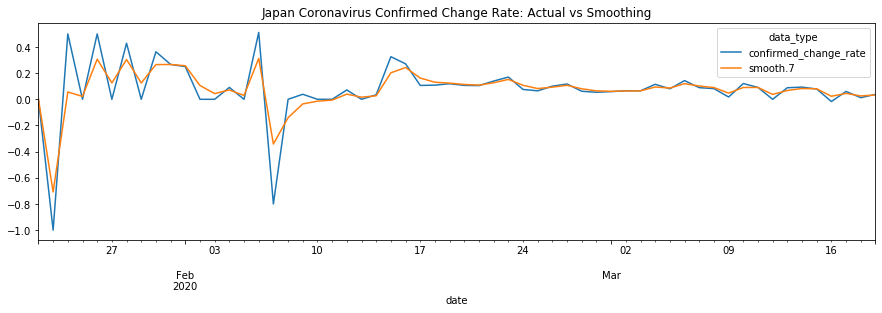

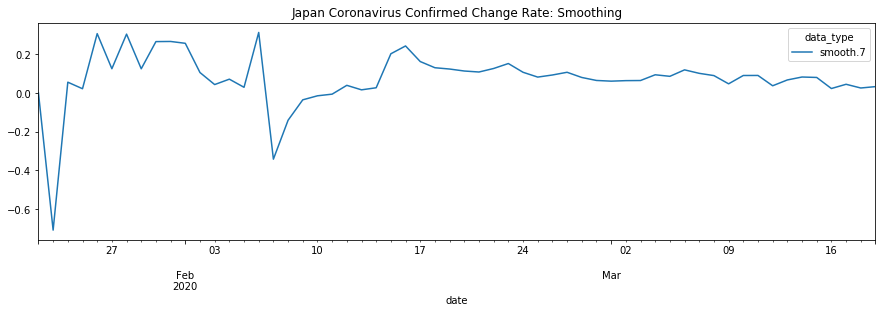

In [19]:
df[['confirmed_change_rate', 'smooth.7']].plot(figsize=(15, 4), title='{} Coronavirus Confirmed Change Rate: Actual vs Smoothing'.format(country))
plt.show()
df[['smooth.7']].plot(figsize=(15, 4), title='{} Coronavirus Confirmed Change Rate: Smoothing'.format(country))
plt.show()

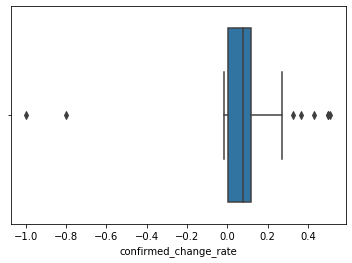

In [20]:
sns.boxplot(df['confirmed_change_rate'])

In [21]:
df[['confirmed', 'smooth.5']].tail()

data_type,confirmed,smooth.5
date,,
2020-03-15,839,0.080827
2020-03-16,825,0.015629
2020-03-17,878,0.045453
2020-03-18,889,0.023400
2020-03-19,924,0.033052


In [22]:
df['confirmed_change_rate_minus_median'] = df['confirmed_change_rate'] - df['confirmed_change_rate'].median()

In [23]:
df['confirmed_change_rate_minus_median']

date
2020-01-22   -0.077068
2020-01-23   -1.077068
2020-01-24    0.422932
2020-01-25   -0.077068
2020-01-26    0.422932
2020-01-27   -0.077068
2020-01-28    0.351503
2020-01-29   -0.077068
2020-01-30    0.286568
2020-01-31    0.189598
2020-02-01    0.172932
2020-02-02   -0.077068
2020-02-03   -0.077068
2020-02-04    0.013841
2020-02-05   -0.077068
2020-02-06    0.434043
2020-02-07   -0.877068
2020-02-08   -0.077068
2020-02-09   -0.038607
2020-02-10   -0.077068
2020-02-11   -0.077068
2020-02-12   -0.005640
2020-02-13   -0.077068
2020-02-14   -0.042586
2020-02-15    0.248513
2020-02-16    0.194118
2020-02-17    0.028992
2020-02-18    0.031040
2020-02-19    0.041979
2020-02-20    0.029315
2020-02-21    0.027694
2020-02-22    0.062276
2020-02-23    0.093000
2020-02-24   -0.001597
2020-02-25   -0.012363
2020-02-26    0.023461
2020-02-27    0.039754
2020-02-28   -0.015665
2020-02-29   -0.023126
2020-03-01   -0.018475
2020-03-02   -0.011375
2020-03-03   -0.012222
2020-03-04    0.037735
2020-0

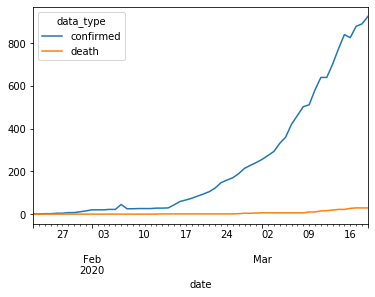

In [24]:
df[['confirmed', 'death']].plot()

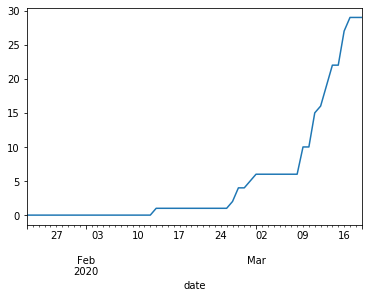

In [25]:
df['death'].plot()

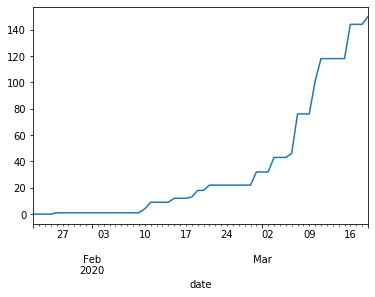

In [26]:
df['recovered'].plot()

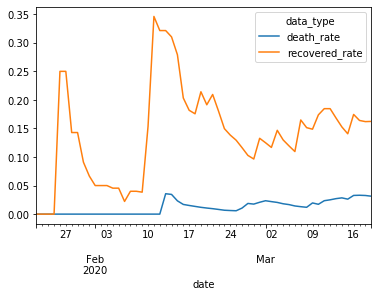

In [27]:
df[['death_rate', 'recovered_rate']].plot() # china looks like this, but i want to see how other countries compare

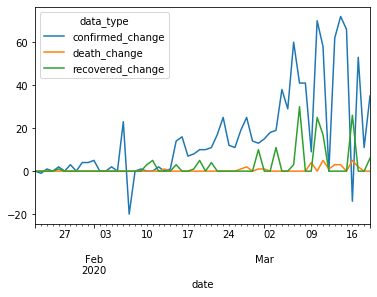

In [28]:
df[['confirmed_change', 'death_change', 'recovered_change']].plot()

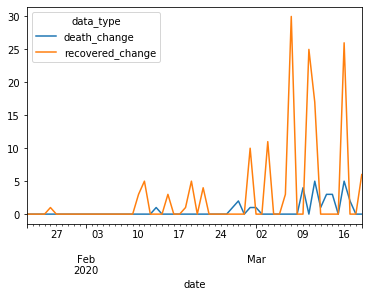

In [29]:
df[['death_change', 'recovered_change']].plot()

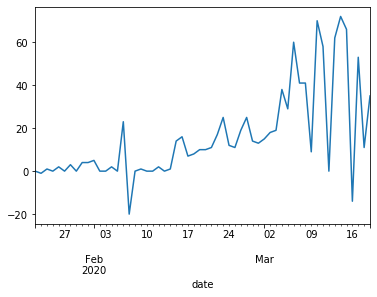

In [30]:
df['confirmed_change'].plot()

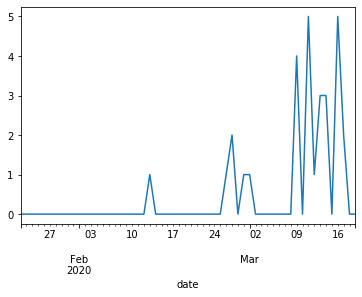

In [31]:
df['death_change'].plot()

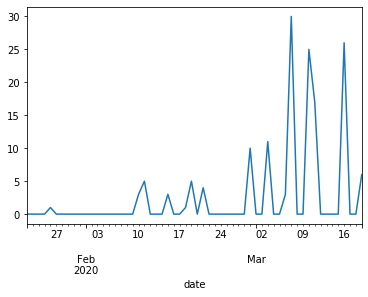

In [32]:
df['recovered_change'].plot()

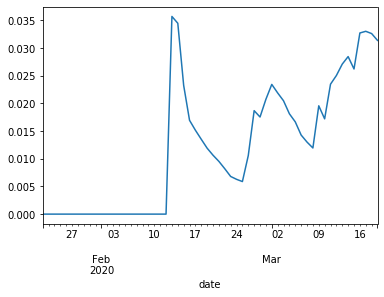

In [33]:
df['death_rate'].plot()

In [34]:
df.columns

Index(['confirmed', 'confirmed_change', 'confirmed_change_rate', 'death',
       'death_change', 'death_change_rate', 'death_rate', 'recovered',
       'recovered_change', 'recovered_change_rate', 'recovered_rate',
       'smooth.5', 'smooth.7', 'smooth.9',
       'confirmed_change_rate_minus_median'],
      dtype='object', name='data_type')

In [35]:
eda_df = df[['confirmed_change', 'death_change']]

In [36]:
eda_df.head()

data_type,confirmed_change,death_change
date,,
2020-01-22,0.0,0.0
2020-01-23,-1.0,0.0
2020-01-24,1.0,0.0
2020-01-25,0.0,0.0
2020-01-26,2.0,0.0


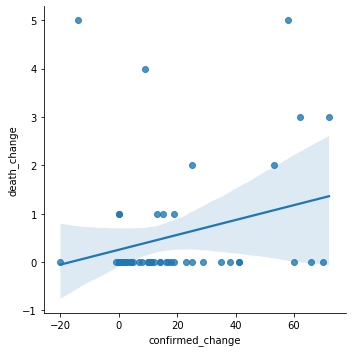

In [37]:
sns.lmplot(x='confirmed_change', y='death_change', data=eda_df)

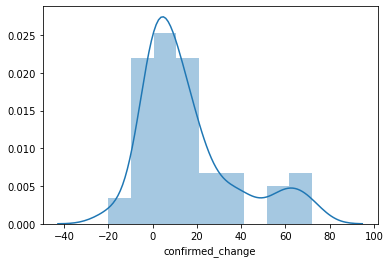

In [38]:
sns.distplot(df['confirmed_change'])

In [39]:
eda_df = eda_df[20:]

In [40]:
eda_df.head()

data_type,confirmed_change,death_change
date,,
2020-02-11,0.0,0.0
2020-02-12,2.0,0.0
2020-02-13,0.0,1.0
2020-02-14,1.0,0.0
2020-02-15,14.0,0.0


In [41]:
for i in range(1, 10):
    col_name = 'confirmed_change_{}'.format(abs(i))
    eda_df[col_name] = eda_df['confirmed_change'].shift(i)
    
columns = sorted(eda_df.columns)
eda_df = eda_df[columns]
eda_df = eda_df.fillna(0)
eda_df.head()

data_type,confirmed_change,confirmed_change_1,confirmed_change_2,confirmed_change_3,confirmed_change_4,confirmed_change_5,confirmed_change_6,confirmed_change_7,confirmed_change_8,confirmed_change_9,death_change
date,,,,,,,,,,,
2020-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-12,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-02-14,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-15,14.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
eda_df.corr()

data_type,confirmed_change,confirmed_change_1,confirmed_change_2,confirmed_change_3,confirmed_change_4,confirmed_change_5,confirmed_change_6,confirmed_change_7,confirmed_change_8,confirmed_change_9,death_change
data_type,,,,,,,,,,,
confirmed_change,1.000000,0.249591,0.314622,0.368313,0.610272,0.273489,0.313895,0.584126,0.361710,0.511544,0.149534
confirmed_change_1,0.249591,1.000000,0.279204,0.322581,0.421792,0.630071,0.281808,0.322979,0.615440,0.373432,0.403715
confirmed_change_2,0.314622,0.279204,1.000000,0.325126,0.330228,0.494235,0.741756,0.357984,0.331478,0.713136,0.306686
confirmed_change_3,0.368313,0.322581,0.325126,1.000000,0.422023,0.295222,0.465750,0.734931,0.419785,0.288966,0.655133
confirmed_change_4,0.610272,0.421792,0.330228,0.422023,1.000000,0.571830,0.472490,0.641724,0.735578,0.593761,0.172315
confirmed_change_5,0.273489,0.630071,0.494235,0.295222,0.571830,1.000000,0.515825,0.408947,0.749515,0.703760,0.390482
confirmed_change_6,0.313895,0.281808,0.741756,0.465750,0.472490,0.515825,1.000000,0.437878,0.534568,0.708511,0.538466
confirmed_change_7,0.584126,0.322979,0.357984,0.734931,0.641724,0.408947,0.437878,1.000000,0.551617,0.465677,0.403689
confirmed_change_8,0.361710,0.615440,0.331478,0.419785,0.735578,0.749515,0.534568,0.551617,1.000000,0.675290,0.285696


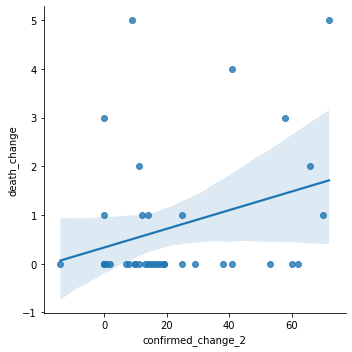

In [43]:
sns.lmplot(x='confirmed_change_2', y='death_change', data=eda_df)

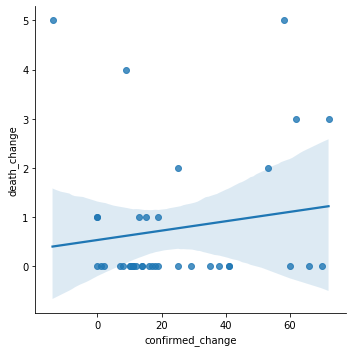

In [44]:
sns.lmplot(x='confirmed_change', y='death_change', data=eda_df)

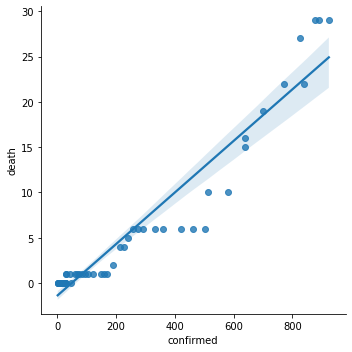

In [45]:
sns.lmplot(x='confirmed', y='death', data=df)

In [46]:
df[['confirmed', 'death']].corr()

data_type,confirmed,death
data_type,,
confirmed,1.000000,0.961715
death,0.961715,1.000000


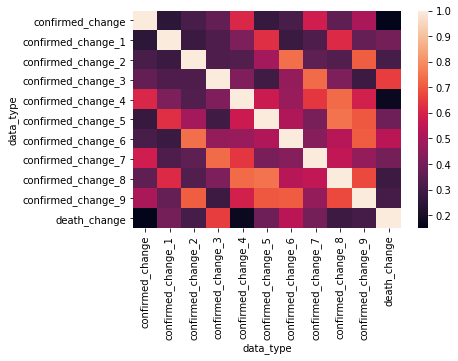

In [47]:
sns.heatmap(eda_df.corr())

In [48]:
eda_df.head()

data_type,confirmed_change,confirmed_change_1,confirmed_change_2,confirmed_change_3,confirmed_change_4,confirmed_change_5,confirmed_change_6,confirmed_change_7,confirmed_change_8,confirmed_change_9,death_change
date,,,,,,,,,,,
2020-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-12,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-02-14,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-15,14.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


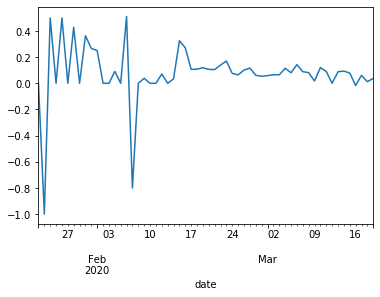

In [49]:
df['confirmed_change_rate'].plot()

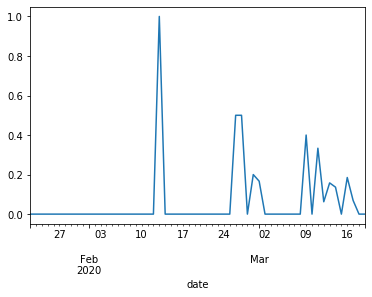

In [50]:
df['death_change_rate'].plot()

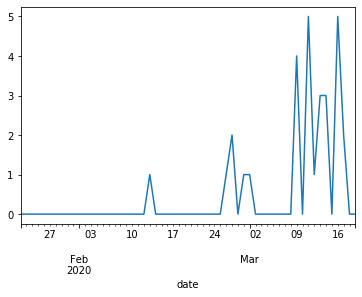

In [51]:
df['death_change'].plot()

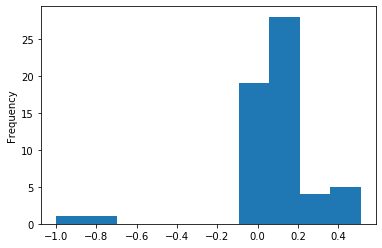

In [52]:
df['confirmed_change_rate'].plot.hist()

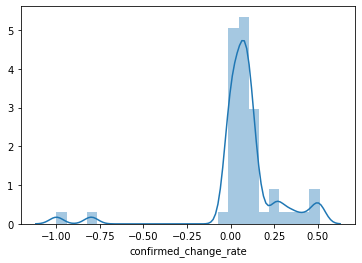

In [53]:
sns.distplot(df['confirmed_change_rate'])

In [82]:
italy_df = get_country_data('Italy')
italy_df.tail(3)

data_type,confirmed,confirmed_change,confirmed_change_rate,death,death_change,death_change_rate,death_rate,recovered,recovered_change,recovered_change_rate,recovered_rate
date,,,,,,,,,,,
2020-03-17,31506,3526.0,0.111915,2503,345.0,0.137835,0.079445,2941,192.0,0.065284,0.093347
2020-03-18,35713,4207.0,0.117800,2978,475.0,0.159503,0.083387,4025,1084.0,0.269317,0.112704
2020-03-19,41035,5322.0,0.129694,3405,427.0,0.125404,0.082978,4440,415.0,0.093468,0.108200


In [83]:
germany_df = get_country_data('Germany')
germany_df.tail(3)

data_type,confirmed,confirmed_change,confirmed_change_rate,death,death_change,death_change_rate,death_rate,recovered,recovered_change,recovered_change_rate,recovered_rate
date,,,,,,,,,,,
2020-03-17,9257,1985.0,0.214432,24,7.0,0.291667,0.002593,67,0.0,0.000000,0.007238
2020-03-18,12327,3070.0,0.249047,28,4.0,0.142857,0.002271,105,38.0,0.361905,0.008518
2020-03-19,15320,2993.0,0.195366,44,16.0,0.363636,0.002872,113,8.0,0.070796,0.007376


In [84]:
japan_df = get_country_data('Japan')
japan_df.tail(3)

data_type,confirmed,confirmed_change,confirmed_change_rate,death,death_change,death_change_rate,death_rate,recovered,recovered_change,recovered_change_rate,recovered_rate
date,,,,,,,,,,,
2020-03-17,878,53.0,0.060364,29,2.0,0.068966,0.033030,144,0.0,0.00,0.164009
2020-03-18,889,11.0,0.012373,29,0.0,0.000000,0.032621,144,0.0,0.00,0.161980
2020-03-19,924,35.0,0.037879,29,0.0,0.000000,0.031385,150,6.0,0.04,0.162338


In [85]:
india_df = get_country_data('India')
india_df.tail(3)

data_type,confirmed,confirmed_change,confirmed_change_rate,death,death_change,death_change_rate,death_rate,recovered,recovered_change,recovered_change_rate,recovered_rate
date,,,,,,,,,,,
2020-03-17,142,23.0,0.161972,3,1.0,0.333333,0.021127,14,1.0,0.071429,0.098592
2020-03-18,156,14.0,0.089744,3,0.0,0.000000,0.019231,14,0.0,0.000000,0.089744
2020-03-19,194,38.0,0.195876,4,1.0,0.250000,0.020619,15,1.0,0.066667,0.077320


In [89]:
italy = italy_df['confirmed'].astype(int)
germany = germany_df['confirmed'].astype(int)
japan = japan_df['confirmed'].astype(int)
india = india_df['confirmed'].astype(int)

combined_df = pd.DataFrame({'italy':italy, 'germany':germany, 'japan':japan, 'india':india})
combined_df.tail(3)

,italy,germany,japan,india
date,,,,
2020-03-17,31506.0,9257.0,878,142.0
2020-03-18,35713.0,12327.0,889,156.0
2020-03-19,41035.0,15320.0,924,194.0


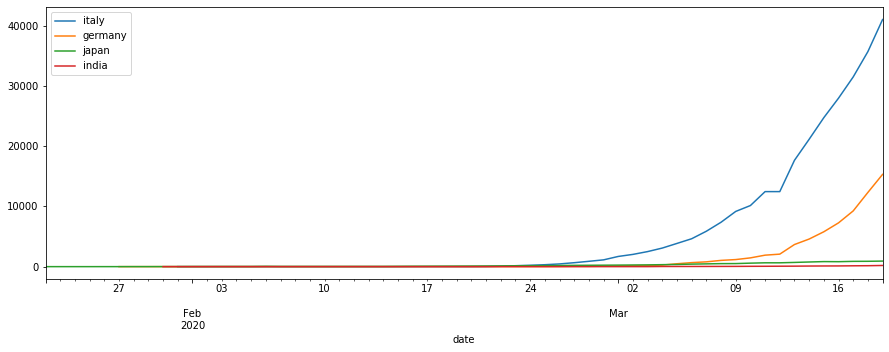

In [93]:
combined_df.plot(figsize=(15, 5))